In [1]:
!pip install pandas numpy scikit-learn catboost matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.5 MB/s eta 0:00:00


In [2]:
!pip install --force-reinstall numpy
!pip install --force-reinstall catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 42.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
  Using cached catboost-1.2.8-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.4 MB

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import pandas as pd

crop_df = pd.read_csv("Crop_recommendation.csv")

unique_labels = crop_df['label'].nunique()
all_labels = crop_df['label'].unique()

print(f"Number of unique crop labels: {unique_labels}")
print("Crop labels:", all_labels)


Number of unique crop labels: 22
Crop labels: ['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']


In [6]:
crop_df = pd.read_csv("Crop_recommendation.csv")

le = LabelEncoder()
crop_df['crop_encoded'] = le.fit_transform(crop_df['label'])

X = crop_df[['temperature', 'humidity', 'ph']]
y = crop_df['crop_encoded']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

catboost = CatBoostClassifier(verbose=0)
catboost.fit(X_train, y_train)
y_pred = catboost.predict(X_test)

baseline = GaussianNB()
baseline.fit(X_train, y_train)
base_pred = baseline.predict(X_test)


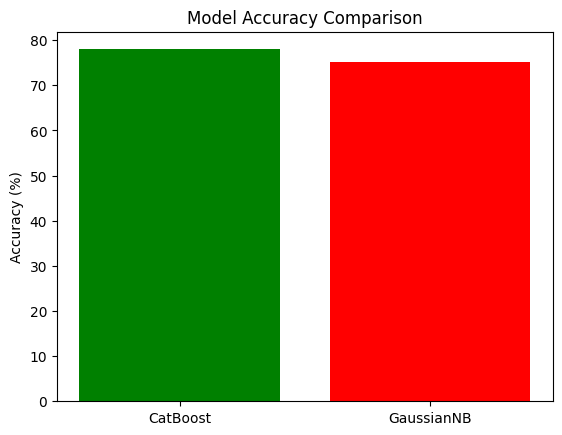

In [7]:
acc_cat = accuracy_score(y_test, y_pred)
acc_base = accuracy_score(y_test, base_pred)

plt.bar(["CatBoost", "GaussianNB"], [acc_cat*100, acc_base*100], color=['green', 'red'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.show()


In [8]:
params = {
    'depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'iterations': [200, 300]
}
grid = GridSearchCV(CatBoostClassifier(verbose=0), params, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)
catboost_best = grid.best_estimator_


In [9]:
def predict_top5_crops(temp, moisture, ph, model, encoder):
    input_df = pd.DataFrame([[temp, moisture, ph]], columns=['temp', 'moisture', 'ph'])
    probs = model.predict_proba(input_df)[0]
    top5_idx = np.argsort(probs)[::-1][:5]
    return encoder.inverse_transform(top5_idx)


In [10]:
rice_df = pd.read_csv("RICE_TNAU_STXT.csv")

def suggest_rice_varieties(district, month_str, soil_texture):

    month_str = month_str.strip().lower().capitalize()
    district = district.strip().lower()
    soil_texture = soil_texture.strip().lower()

    rice_df['TNDST'] = rice_df['TNDST'].str.strip().str.lower()
    rice_df['STMT'] = rice_df['STMT'].str.strip().str.lower().str.capitalize()
    rice_df['EDMT'] = rice_df['EDMT'].str.strip().str.lower().str.capitalize()
    rice_df['STXT'] = rice_df['STXT'].str.strip().str.lower()

    filtered_df = rice_df[
        (rice_df['TNDST'] == district) &
        (rice_df['STXT'] == soil_texture) &
        (rice_df['STMT'] <= month_str) &
        (rice_df['EDMT'] >= month_str)
    ]

    return filtered_df['VRTS'].unique()


In [11]:
def final_prediction(temp, moisture, ph, district, month, soil_texture):

    top_crops = predict_top5_crops(temp, moisture, ph, catboost, le)
    print("🌿 Top 5 Crop Predictions with Confidence:")
    for crop, confidence in top_crops:
        print(f" - {crop}: {confidence:.2f}%")

    crop_names = [crop.lower() for crop, _ in top_crops]
    if "rice" in crop_names:
        print("\n🌾 Since 'Rice' is among top crops, suggesting suitable rice varieties...")

        varieties = suggest_rice_varieties(district, month, soil_texture)

        if len(varieties) == 0:
            print("❗ No matching rice varieties found for the given configuration.")
        else:
            print("✅ Recommended Rice Varieties:")
            for v in varieties:
                print(" -", v)

    else:
        print("\n🌽 'Rice' not in top 5 suggestions. Try growing another from above.")


In [12]:
def predict_top5_crops(temp, moisture, ph, model, label_encoder):

    input_data = pd.DataFrame([[temp, moisture, ph]], columns=['temperature', 'humidity', 'ph'])
    proba = model.predict_proba(input_data)[0]
    crop_classes = label_encoder.inverse_transform(np.arange(len(proba)))

    crop_confidence = list(zip(crop_classes, proba * 100))
    top5 = sorted(crop_confidence, key=lambda x: x[1], reverse=True)[:5]

    return top5

In [13]:
final_prediction(
    temp=20.87,
    moisture=82.00,
    ph=7.04,
    district="Coimbatore",
    month="August",
    soil_texture="Silty clay"
)


🌿 Top 5 Crop Predictions with Confidence:
 - rice: 96.78%
 - cotton: 2.18%
 - pomegranate: 0.59%
 - jute: 0.18%
 - grapes: 0.11%

🌾 Since 'Rice' is among top crops, suggesting suitable rice varieties...
✅ Recommended Rice Varieties:
 - CO 43


In [14]:
!pip install fastapi nest-asyncio pyngrok uvicorn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.9 MB/s eta 0:00:00


In [15]:
!pip install catboost joblib pydantic

In [16]:
import joblib
joblib.dump(catboost_best, 'catboost_model.cbm')


['catboost_model.cbm']

In [17]:
!pip install flask-ngrok

In [18]:
!pkill -f ngrok

In [ ]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from pyngrok import ngrok

model = joblib.load('catboost_model.cbm')

crop_df = pd.read_csv("Crop_recommendation.csv")
le = LabelEncoder()
le.fit(crop_df['label'])

rice_df = pd.read_csv("RICE_TNAU_STXT.csv")

app = Flask(__name__)

def predict_top5_crops(temp, moisture, ph):
    input_data = pd.DataFrame([[temp, moisture, ph]], columns=['temperature', 'humidity', 'ph'])
    proba = model.predict_proba(input_data)[0]
    crop_classes = le.inverse_transform(np.arange(len(proba)))
    crop_confidence = list(zip(crop_classes, proba * 100))
    top5 = sorted(crop_confidence, key=lambda x: x[1], reverse=True)[:5]
    return top5

def suggest_rice_varieties(district, month_str, soil_texture):
    month_str = month_str.strip().lower().capitalize()
    district = district.strip().lower()
    soil_texture = soil_texture.strip().lower()

    rice_df['TNDST'] = rice_df['TNDST'].str.strip().str.lower()
    rice_df['STMT'] = rice_df['STMT'].str.strip().str.lower().str.capitalize()
    rice_df['EDMT'] = rice_df['EDMT'].str.strip().str.lower().str.capitalize()
    rice_df['STXT'] = rice_df['STXT'].str.strip().str.lower()

    filtered_df = rice_df[
        (rice_df['TNDST'] == district) &
        (rice_df['STXT'] == soil_texture) &
        (rice_df['STMT'] <= month_str) &
        (rice_df['EDMT'] >= month_str)
    ]

    return filtered_df['VRTS'].unique()

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.get_json()
        temp = data['temperature']
        moisture = data['humidity']
        ph = data['ph']
        district = data['district']
        month = data['month']
        soil_texture = data['soil_texture']

        top_crops = predict_top5_crops(temp, moisture, ph)
        result = {"top_crops": top_crops}

        crop_names = [crop.lower() for crop, _ in top_crops]
        if "rice" in crop_names:
            varieties = suggest_rice_varieties(district, month, soil_texture)
            result["rice_varieties"] = list(varieties) if len(varieties) else []

        return jsonify(result)

    except Exception as e:
        return jsonify({"error": str(e)}), 500

ngrok.set_auth_token("<---ngrok token here-->")
public_url = ngrok.connect(8000)
print("Public URL:", public_url)


if __name__ == '__main__':
    app.run(port=8000)


Public URL: NgrokTunnel: "https://8e74-130-211-244-83.ngrok-free.app" -> "http://localhost:8000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:8000
INFO:werkzeug:Press CTRL+C to quit
